In [17]:
pip install astroquery 

Note: you may need to restart the kernel to use updated packages.


In [18]:
from astroquery.gaia import Gaia
import pandas as pd
import numpy as np

In [19]:
#Search Field (edit to reproduce results)
ra_center = 56 # Right Ascension in degrees
dec_center = 56 # Declination in degrees
radius_deg = 1.5 # Radius in degrees

# Astronomical Data Query Language to work with the data release (filters data)
query = f""" SELECT
  source_id, ra, dec,
  parallax, parallax_error,
  pmra, pmra_error,
  pmdec, pmdec_error,
  phot_g_mean_mag, bp_rp,
  ruwe, visibility_periods_used
FROM gaiadr3.gaia_source
WHERE 1 = CONTAINS(
  POINT('ICRS', ra, dec),
  CIRCLE('ICRS', {ra_center}, {dec_center}, {radius_deg}))
AND ruwe < 1.2
AND visibility_periods_used >= 15
AND parallax IS NOT NULL
AND pmra IS NOT NULL
AND pmdec IS NOT NULL"""

In [20]:
#Run the query, then convert to a Pandas Data Frame
job = Gaia.launch_job_async(query, output_format="csv", dump_to_file=False)
results = job.get_results()
data_frame = results.to_pandas()
print(data_frame.head())
data_frame.to_csv("gaia_DR3_field.csv", index=False)
print("CSV file saved as gaia_DR3_field.csv")

INFO: Query finished. [astroquery.utils.tap.core]
            source_id         ra        dec  parallax  parallax_error  \
0  469519369471310080  58.496505  56.174068  0.497261        0.283822   
1  469519949283608448  58.600888  56.220796  0.289192        0.229181   
2  469588222084420096  58.179617  56.459953  0.765410        0.340269   
3  469500536031567872  58.673437  55.904503  0.132516        0.114487   
4  469500536031568640  58.666861  55.905848 -0.697294        0.480522   

       pmra  pmra_error     pmdec  pmdec_error  phot_g_mean_mag     bp_rp  \
0 -0.226478    0.301550 -0.861311     0.270877        19.350645  1.813965   
1  1.090970    0.247281  0.205281     0.230899        19.161396  1.817463   
2  0.683904    0.303955 -1.693249     0.345572        19.367632  2.053946   
3  0.293443    0.119674 -0.662868     0.103415        17.710910  1.874170   
4 -0.567546    0.490482 -0.740648     0.458318        19.841574  2.188986   

       ruwe  visibility_periods_used  
0  0.9557

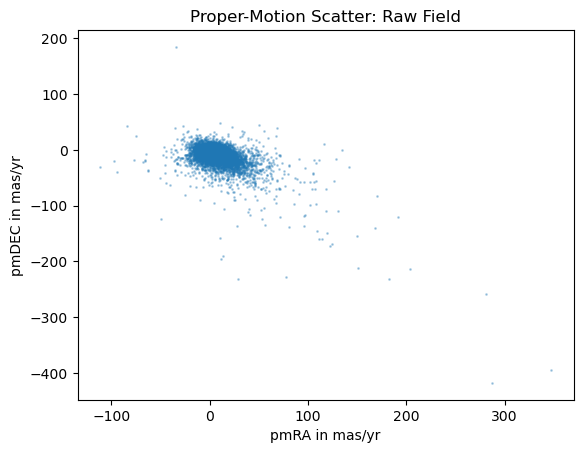

In [21]:
import matplotlib.pyplot as plt

plt.scatter(data_frame['pmra'], data_frame['pmdec'],s=1, alpha=0.3)
plt.xlabel('pmRA in mas/yr')
plt.ylabel('pmDEC in mas/yr')
plt.title('Proper-Motion Scatter: Raw Field')

plt.show()

In [22]:
#Run DBSCAN and label members
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
df = pd.read_csv("gaia_DR3_field.csv")

#only keels the needed features
col_need = ["pmra", "pmdec", "parallax"]
#trim outliers to clean up the density scale
dfc = df.dropna(subset=col_need).copy()
for c in ["pmra", "pmdec"]:
    q1, q99 = np.percentile(dfc[c], [1, 99])
    dfc = dfc[(dfc[c] >= q1) & (dfc[c] <= q99)].copy()
print(f"Rows Usable for Clustering: {len(dfc)}")

Rows Usable for Clustering: 191687


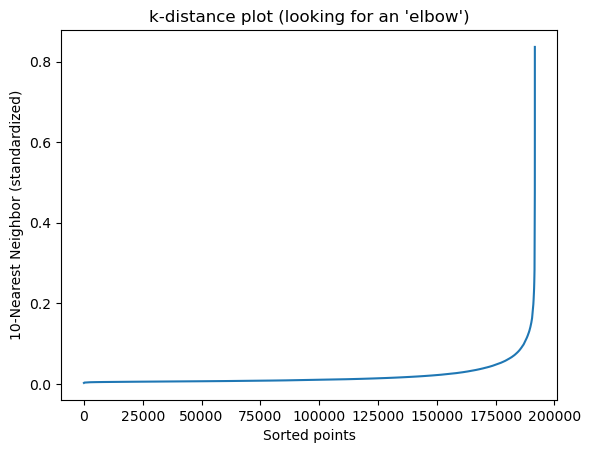

Suggested eps (standard units): ~0.030


In [23]:
#Starting with Proper motions, adding in parallax once a clump is clear in proper motion
X = dfc[["pmra", "pmdec"]].to_numpy()
# standardize to use DBSCAN (distance-based)
scale = StandardScaler()
X_z = scale.fit_transform(X)
# Pick eps (eps(epsilon) : the max distance between two points to consider them neighbors)
minimum_samples = 10 #can be anywhere between 10 and 30 
nbrs = NearestNeighbors(n_neighbors=minimum_samples).fit(X_z)
dists, _ = nbrs.kneighbors(X_z)
k_dist = np.sort(dists[:, -1]) # the distance to the kth neighbor 

#plot to visualize and check
plt.plot(k_dist)
plt.ylabel(f"{minimum_samples}-Nearest Neighbor (standardized)")
plt.xlabel("Sorted points")
plt.title("k-distance plot (looking for an 'elbow')")
plt.show()

#auto-suggestion for eps
eps_guess = np.percentile(k_dist, 85) #85-95 percentile band
print(f"Suggested eps (standard units): ~{eps_guess:.3f}")


In [24]:
#eps guess is pretty good 
eps = float(eps_guess) #can change manually 
#run DBSCAN
db = DBSCAN(eps=eps, min_samples=minimum_samples, n_jobs=-1)
labels = db.fit_predict(X_z)
dfc["cluster"] = labels
print(dfc["cluster"].value_counts().head(10)) #-1 would be noise

cluster
 0     163897
-1      23757
 31       121
 8         95
 16        84
 7         81
 1         80
 41        62
 76        54
 46        52
Name: count, dtype: int64


In [25]:
# Keeps only true clusters
clusters = (dfc[dfc["cluster"]>=0].groupby("cluster").agg(
    N=("cluster","size"),
    pmra_med=("pmra","median"),
    pmdec_med=("pmdec","median"),
    par_med=("parallax","median"),
    pmra_std=("pmra","std"),
    pmdec_std=("pmdec","std"),
    par_std=("parallax","std"),
    ).sort_values("N", ascending=False))
print(clusters.head(10))
#choose the largest candidate
if not clusters.empty:
    best = clusters.index[0]
    members = dfc[dfc["cluster"]==best]
    print(f"\nChosen cluster {best} with N={len(members)}")
else: 
    members = pd.DataFrame()
    print("No Clusters Found - adjust eps/ minimum_samples")   

              N  pmra_med  pmdec_med   par_med  pmra_std  pmdec_std   par_std
cluster                                                                      
0        163897  0.227962  -0.565584  0.321884  1.179055   1.284879  0.554643
31          121  3.891177  -4.342325  0.717218  0.103431   0.154508  0.690282
8            95  4.275154  -2.215622  0.708582  0.113102   0.115479  0.708266
16           84  1.862154  -4.823940  0.795181  0.175536   0.055545  0.713222
7            81 -1.814010   2.309974  0.570117  0.100322   0.102958  0.687694
1            80 -2.760850   1.215414  0.569416  0.109454   0.104392  0.534816
41           62  0.657454  -4.775705  0.745208  0.089191   0.078185  0.655256
76           54  1.582902  -5.040762  0.796004  0.093061   0.074826  0.484712
46           52  4.072947  -3.328039  0.772818  0.126744   0.047034  0.567680
18           48  3.630347  -0.238912  0.357357  0.080226   0.076263  0.655314

Chosen cluster 0 with N=163897


In [16]:
#validation plots ie. members vs field, parallax distributions
#uncertainty metrics